<a href="https://colab.research.google.com/github/gthaxton/FPM/blob/main/fpm_4_docker_(11)GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import tensorflow and verify if is available any GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
# import tensorflow and verify if is available any GPU
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
       tf.config.experimental.set_memory_growth(gpu,True)

In [ ]:
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

No GPU, using /device:CPU:0.


In [ ]:

!pip install tensorflow_addons
!pip install stn
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.2/289.2 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00


In [ ]:
#imports the required libraries

import scipy.io as sio
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.compat.v1  import  roll
import numpy as np
#import cv2
from stn import spatial_transformer_network as transformer
from tensorflow.keras import optimizers
from tensorflow.keras.models import *
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout, concatenate, Add, Lambda, Subtract,Layer,Cropping2D,Reshape,Dense
from tensorflow.keras.optimizers import *
from math import pi as pi
from scipy import signal
from tensorflow.keras import backend as K
from math import pi as pi
import matplotlib.pyplot as plt
import math
import os
import random
from tqdm import tqdm
from PIL import Image

from tensorflow.keras import initializers


from scipy.ndimage import label, generate_binary_structure
from scipy.io import loadmat

from tensorflow.keras.constraints import Constraint
from mpl_toolkits.axes_grid1 import make_axes_locatable

import glob
import imageio
from skimage import data, color
from skimage.io         import imread, imsave
from skimage.measure    import regionprops
from skimage import img_as_ubyte
from skimage.transform import rescale, resize, downscale_local_mean


print(tf.__version__)

tf.config.run_functions_eagerly(False)

# file with functions that we use to do the FPM
from fpm_functions import CustomConv, take_one, Between, ConvexCombination, OutputLayer, LayerBis, pos_cal, pos_angle, pos_distance, BilinearInterpolation

2.15.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path="/content/drive/MyDrive/Fourier-Ptychography-master/Data/bloodsmear_green.mat"

In [ ]:
data = loadmat(path)

In [ ]:
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'aberration', 'imlow_HDR', 'theta', 'wlength', 'xint', 'yint', 'z'])

In [ ]:
data['wlength']

array([[5.32e-07]])

In [ ]:
data['imlow_HDR'].shape

(128, 128, 225)

In [ ]:
data['theta']

array([[0]], dtype=uint8)

In [ ]:
# set microscope and image parameters

#path_square
path="/content/drive/MyDrive/Fourier-Ptychography-master/Data/bloodsmear_green.mat"

#how much the resolution will be increased
index_downSample = 4

# wavefront length
wlength =  5.32e-07

# numerical aperture
NA = 0.1
k0 = 2 * math.pi / wlength

#magnification of len
magnif = 10

#pixel size
pixel_size = (1.845*1e-6)
spsize =(1.845*1e-6) #pixel_size/magnif
psize = spsize/index_downSample

#image size in low resolution
original_size = 128

#image size in high resolution
imSize = int(np.ceil(original_size*index_downSample))

#center of the image
imCenter = int(imSize / 2)

# root of the leds matrix size
arraysize = 15

# distance between two leds
NAstep = 0.04

# distance between the led matrix and sample
dz=90.88

Format = "Square"


dkxy = 2*pi/(psize*imSize)
cutoffFrequency = ( NA* k0 / dkxy)

In [ ]:
pip install scipy


In [ ]:
# Functions

# This function reads a txt file that has the led positions and puts the values into an array
def spiral_kxky(filename, ledNum):
    kxky = [[], []]
    with open(filename, 'r') as file:
        for line in file:
            for j, value in enumerate(line.split(",")):
                kxky[j].append(np.float64(value))
    kxky = np.asarray(kxky)
    kxky = kxky.T
    return kxky[:ledNum, :]

# This function shows the result of the neural network result, does the Fourier
# inverse transform from the weights of the complex object and thus as a result
# has the reconstructed image in phase and intensity

def show_result(model,mask, show=0, noShow=10,size=10):
    w_conv_Or = model.get_layer('O_FTr').get_weights()
    w_conv_Oi = model.get_layer('O_FTi').get_weights()
    w_conv_Or_array = np.asarray(w_conv_Or)
    w_conv_Oi_array = np.asarray(w_conv_Oi)
    c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
    c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))

    c_complex = (c_real + 1j * c_imag)*mask
    c_abs = np.abs(c_complex)
    c_phase = np.angle(c_complex+pi)
    im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)), deg=True)
    c_complexFTLog = np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(c_complex)))))
#     objFTLog = np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(obj)))))


    if show:
        plt.figure(figsize=(20,20))
        # plt.subplot(337),plt.imshow(c_phase[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray'),plt.title('recover FT phase')
        plt.subplot(333),plt.imshow(np.log(c_abs[noShow:imSize-noShow, noShow:imSize-noShow]+1), cmap='gray'),plt.title('recover FT')
        plt.subplot(332),plt.imshow(im_phase[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray'),plt.title('recover (phase)')
        plt.colorbar()
        plt.subplot(331),plt.imshow(im_spatial[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray'),plt.title('recover (abs)')
#         plt.subplot(334),plt.imshow(np.abs(obj[noShow:imSize-noShow, noShow:imSize-noShow]), cmap='gray'),plt.title('high res (abs)')
#         plt.subplot(335),plt.imshow(np.angle(obj[noShow:imSize-noShow, noShow:imSize-noShow]), cmap='gray'),plt.title('high res (phase)')
#         plt.subplot(336),plt.imshow(objFTLog[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray'),plt.title('high res FT')

    return c_complex

# Custom callback used to see the low resolution images and TF generated by the network at the end of each batch
class SeeImages(keras.callbacks.Callback):
    def __init__(self, image_number):
        self.i = image_number
    def on_train_batch_end(self, batch, logs=None):
        print(batch)
        plt.figure()
        plt.subplot(121)
        plt.imshow(self.model.layers[50].a[0].numpy()[:,:,0], cmap='gray')
        #print(model_with_noise_trained.layers[46].a[0].numpy())
        plt.subplot(122)
        plt.imshow(np.log(self.model.layers[45].a[0].numpy()[:,:,0]), cmap='gray')
        plt.show()
        plt.subplot(122)
        plt.imshow(imgs_test_predict_resize[ self.i ,:,:,0] , cmap='gray')
        plt.show()

In [ ]:
def save_data_for_figures(model, mask, file_prefix='figure_data_', noShow=10):
    w_conv_Or = model.get_layer('O_FTr').get_weights()
    w_conv_Oi = model.get_layer('O_FTi').get_weights()
    w_conv_Or_array = np.asarray(w_conv_Or)
    w_conv_Oi_array = np.asarray(w_conv_Oi)
    c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
    c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))

    c_complex = (c_real + 1j * c_imag)*mask
    c_abs = np.abs(c_complex)
    c_phase = np.angle(c_complex+np.pi)
    im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))
    im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)), deg=True)

    # Enregistrer les données pour 'recover FT'
    scipy.io.savemat(f'{file_prefix}recover_FT.mat', {'data': np.log(c_abs[noShow:imSize-noShow, noShow:imSize-noShow]+1)})

    # Enregistrer les données pour 'recover (phase)'
    scipy.io.savemat(f'{file_prefix}recover_phase.mat', {'data': im_phase[noShow:imSize-noShow, noShow:imSize-noShow]})

    # Enregistrer les données pour 'recover (abs)'
    scipy.io.savemat(f'{file_prefix}recover_abs.mat', {'data': im_spatial[noShow:imSize-noShow, noShow:imSize-noShow]})

    return c_complex


47.232


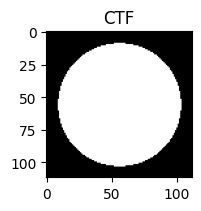

In [ ]:
# Generate CTF
dkxy = 2*pi/(psize*imSize)
cutoffFrequency = ( NA* k0 / dkxy)
center = [imCenter, imCenter]
kYY, kXX = np.ogrid[:imSize, :imSize]
CTF = np.sqrt((kXX - center[0]) ** 2 + (kYY - center[1]) ** 2) <= (cutoffFrequency)
CTF = CTF.astype(float)

print(cutoffFrequency)
# Show CTF
plt.figure()
noShow = 200
plt.subplot(1, 3, 3),plt.imshow(CTF[noShow:imSize-noShow, noShow:imSize-noShow], cmap='gray'),plt.title('CTF')
plt.show()

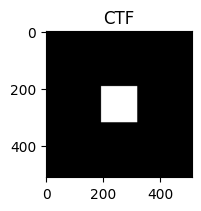

In [ ]:
# Generate square
dkxy = 2*pi/(psize*imSize)
cutoffFrequency = (NA * k0 / dkxy)
center = [imCenter, imCenter]
kYY, kXX = np.ogrid[:imSize, :imSize]
SQUARE = (kXX<(imSize/2 + original_size/2))&(kXX>(imSize/2 - original_size/2))&(kYY<(imSize/2 + original_size/2))&(kYY>(imSize/2 - original_size/2))


# Show CTF
plt.figure()
plt.subplot(1, 3, 3),plt.imshow(SQUARE, cmap='gray'),plt.title('CTF')
plt.show()

In [ ]:

# apprentissage des nouvelles positions
class pos_distance(Layer):
    def __init__(self,NAstep, **kwargs):
        self.i = 0
        self.NAstep = NAstep
        super(pos_distance, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                     shape=((2,1)), # Adding one dimension for broadcasting
                                     initializer='ones',# Try also 'ones' and 'uniform'
                                     trainable=True
                                     )

        super(pos_distance, self).build(input_shape)

    def call(self, x,y):
        a = self.lambd2[0,0]
        a = tf.keras.backend.cast(a, dtype='float32')
        b = self.lambd2[1,0]
        new_pos_x = tf.math.multiply(x,a)
        new_pos_y = tf.math.multiply(y,b)
        return new_pos_x,new_pos_y

    def compute_output_shape(self, input_shape):
        return input_shape

In [ ]:
# ajuster les positions par rapport a la distance entre la matrice de led et l'echantillon qui est un paramettre entrainable (h)
class wave_vector(Layer):
    def __init__(self, **kwargs):
        self.i = 0
        super(wave_vector, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                     shape=((1,1)), # Adding one dimension for broadcasting
                                     initializer='zeros',# Try also 'ones' and 'uniform'
                                     trainable=True
                                     )

        super(wave_vector, self).build(input_shape)

    def call(self, x,y):
        h = self.lambd2
        h = tf.keras.backend.cast(h, dtype='float32')
        #b = self.lambd2[1,0]
        sqrt = tf.math.sqrt((x*x) + (y*y) + ((dz+h)*(dz+h)))
        kx_w = -1*(k0*(x/sqrt))/dkxy
        ky_w = -1*(k0*(y/sqrt))/dkxy

        # tf.print(x,y)
        # tf.print(kx_w,ky_w)

        return kx_w,ky_w

    def compute_output_shape(self, input_shape):
        return input_shape


In [ ]:
from PIL import Image
import numpy as np
import scipy.io

def read_tiff(path, n_images):
    """
    path - Path to the multipage-tiff file
    n_images - Number of pages in the tiff file
    """
    img = Image.open(path)
    images = []
    for i in range(n_images):
        try:
            img.seek(i)
            slice_ = np.zeros((img.height, img.width))
            for j in range(slice_.shape[0]):
                for k in range(slice_.shape[1]):
                    slice_[j,k] = img.getpixel((k, j))

            images.append(slice_)

            print(i)
        except EOFError:
            # Not enough frames in img
            break

    return np.array(images)

In [ ]:
# element wise multiplication with a trainable layer
class CustomConv( Layer):
    def __init__(self, output_dims, **kwargs):
        self.output_dims = output_dims

        super(CustomConv, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.kernel = self.add_weight(name='kernel',
                                      shape=self.output_dims,
                                      initializer='ones',
                                      trainable=True)

        super(CustomConv, self).build(input_shape)  # Be sure to call this somewhere!

    def call(self, x,imSize):
        a = tf.keras.backend.reshape(x, shape=(-1,imSize,imSize,1))
        return tf.multiply(a,self.kernel)

    def compute_output_shape(self, input_shape):
        return (self.output_dims)


In [ ]:
device_name = tf.test.gpu_device_name()

2024-06-04 11:24:40.495947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 11:24:40.496066: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 11:24:40.496111: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 11:24:40.496537: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-04 11:24:40.496565: I tensorflow/core/common_runtime/gpu/gpu

In [ ]:
class ConvexCombination(Layer):
    def __init__(self, height=40, width=40, **kwargs):
        super().__init__(**kwargs)
        self.height = height
        self.width = width

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                      shape=(10, 1),
                                      initializer='ones',
                                      trainable=True,
                                      constraint=Between(-1., 1.))
        super().build(input_shape)


    def create_combination(self, ix):
        a, b, c, d, e, f, g, h, i, j = tf.unstack(self.lambd2[:, 0])

        x = ix[0] + self.kx
        y = ix[1] + self.ky

        mag = self.cut_of_frequency
        ctf_before = tf.math.sqrt(tf.add(tf.math.square(x),tf.math.square(y)))


        #ctf = tf.where(tf.math.less_equal(ctf_before,tf.cast(mag, tf.float32)),1*tf.ones_like(ctf_before),0*tf.ones_like(ctf_before))
        ctf =  tf.keras.layers.ReLU(max_value = 1.0)((mag+1)-tf.math.sqrt(tf.math.square(x)+tf.math.square(y)))/1.0
        x1 = x / mag
        y1 = y / mag

        z0 = 1 # piston
        z1 = x1 # x tilt
        z2 = y1 # y tilt
        z3 = ( 2*(tf.math.square(x1)) + 2*(tf.math.square(y1)) - 1) # defocalisation
        z4 = ((tf.math.square(x1)) + -1*(tf.math.square(y1)))#(-1 + 2*(tf.math.square(x1)) + 2*(tf.math.square(y1))) # Astigmatisme à 0
        z5 = (2*x1*y1) # Astigmatisme à 45°
        z6 = (-1*(tf.math.pow(x1,3)) + 3*x1*(tf.math.square(y1)))
        z7 = (-2*x1 + 3*(tf.math.pow(x1,3))  + 3*x1*(tf.math.square(y1)))
        z8  = (-2*x1 + 3*(tf.math.pow(x1,3))  + 3*x1*(tf.math.square(y1)))
        z9  = (-2*y1 + 3*(tf.math.pow(y1,3))  + 3*y1*(tf.math.square(x1)))
        z10 = (tf.math.pow(y1,3)) - 3*x*(tf.math.square(y1))

        linear_comb =  ctf*(a*z0 + b*z1 +  c*z2 + d*z3 + e*z4 + f*z5 + g*z6 + h*z7 +i*z8 +j*z9)

        return ctf, linear_comb

    def call(self, inputs):
        kx, ky, cut_of_frequency = inputs
        self.kx = tf.cast(kx, tf.float32)
        self.ky = tf.cast(ky, tf.float32)
        self.cut_of_frequency = tf.cast(cut_of_frequency, tf.float32)
        xx, yy = tf.meshgrid(tf.range((-self.width / 2), self.width / 2, 1), tf.range((-self.height / 2), self.height / 2, 1))

        ctf, linear_comb = tf.vectorized_map(self.create_combination, (xx,yy))
        pupil = tf.exp(1j * tf.cast(linear_comb, tf.complex64)) * tf.cast(ctf, tf.complex64)

        return pupil


In [ ]:

def ClearComplexObject(model):
    weight_or = np.ndarray((1, imSize, imSize, 1))
    weight_oi = np.ndarray((1, imSize, imSize, 1))
    # Set low res image FT as the initial weight
    imlowFT1 = np.fft.fftshift(np.fft.fft2(np.sqrt(rescale(annots['imgs'][0, :, :, 0], index_downSample, anti_aliasing=False)))).astype(np.complex64)
    weight_or[0, :, :, 0] = np.real(imlowFT1)
    weight_oi[0, :, :, 0] = np.imag(imlowFT1)
    model.get_layer('O_FTr').set_weights(weight_or)
    model.get_layer('O_FTi').set_weights(weight_oi)

def ClearZernikePolynomials(model):
    weight_z1 = np.zeros((10, 1))
    # # Set initial weights for the ZErnike polynomials
    weight_z1[0] = 1
    model.get_layer('inter_z1').set_weights([weight_z1])

def CleanPositionsWeights(model):
    model.get_layer('kx').set_weights([np.ones((1,1))*(0)])
    model.get_layer('ky').set_weights([np.ones((1,1))*(0)])
    model.get_layer('angle').set_weights([np.ones((1,1))*(0)])
    model.get_layer('distance').set_weights([np.ones((2,1))*(1)])
    model.get_layer('dz').set_weights([np.ones((1,1))*(0)])

def SetTrainableLayers(model, pupil,objectComplex,polynomes,kx,ky,angle,distance,dz):
    model.get_layer('P_r').trainable = pupil
    model.get_layer('P_i').trainable = pupil
    model.get_layer('O_FTr').trainable = objectComplex
    model.get_layer('O_FTi').trainable = objectComplex
    model.get_layer('inter_z1').trainable = polynomes
    model.get_layer('kx').trainable = kx
    model.get_layer('ky').trainable = ky
    model.get_layer('angle').trainable = angle
    model.get_layer('distance').trainable = distance
    model.get_layer('dz').trainable = distance

def ClearRAM():
    import gc

    K.clear_session()
    gc.collect()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Input, Lambda
from tensorflow.keras.models import Model

class CropBox(Layer):
    def __init__(self, output_dims, **kwargs):
        super(CropBox, self).__init__(**kwargs)
        # Make sure to accept three dimensions: height, width, and channels
        self.height, self.width, self.channels = output_dims

    def build(self, input_shape):
        # You can define any trainable weights here if needed
        super(CropBox, self).build(input_shape)

    def call(self, x, top_left_x, top_left_y, bottom_right_x, bottom_right_y):
        # Handle cropping logic within TensorFlow's indexing capabilities
        cropped = tf.image.crop_to_bounding_box(x, top_left_y, top_left_x, self.height, self.width)
        return cropped

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.height, self.width, self.channels)

    def get_config(self):
        config = super().get_config()
        config.update({
            "height": self.height,
            "width": self.width,
            "channels": self.channels
        })
        return config


In [ ]:
from tensorflow.keras.layers import Layer

class pos_angle(Layer):
    def __init__(self, **kwargs):
        super(pos_angle, self).__init__(**kwargs)

    def build(self, input_shape):
        self.lambd2 = self.add_weight(name='lambda2',
                                      shape=(1, 1),
                                      initializer='zeros',
                                      trainable=True)
        super(pos_angle, self).build(input_shape)

    def call(self, inputs):
        x, y = inputs  # Assurez-vous que les entrées sont une liste contenant x et y
        a = tf.cast(self.lambd2, dtype='float32')
        new_pos_x = x * tf.math.cos(a) + y * tf.math.sin(a)
        new_pos_y = -x * tf.math.sin(a) + y * tf.math.cos(a)
        return [new_pos_x, new_pos_y]


In [ ]:
device_name = tf.test.gpu_device_name()

In [ ]:
with tf.device(device_name):
  def CreateNNModel():
      # Creates the neural network

      # Initializes input layers
      input_all = Input((2, 1),dtype='float32', name='input_all')  # led positions
      input_measurement = Input((original_size, original_size, 1), name='input_measurement',dtype='float32')  # low-resolution images
      nule = Input((imSize,imSize, 1),dtype='float32', name='input_nule')  # CTF tf.ones(tf.shape(input_CTF), tf.float32)

      hx = int(imCenter - original_size/2)
      hy = int(imCenter + original_size/2)

      # Separates the input_all layer into CTF and led positions
      input_x = Lambda(lambda x:  x[:,0:1,0],name='input_x')(input_all)
      input_y = Lambda(lambda x:x[:,1:2,0],name='input_y')(input_all)

      #Corrects the positions of the DELs

      # Appel correct
      x_i_correct_2, y_i_correct_2 = pos_angle(name='angle')([input_x, input_y])

      x_i_correct_1,y_i_correct_1  = pos_distance(NAstep,name='distance')(x_i_correct_2,y_i_correct_2)

      x_i_correct = pos_cal(name='kx')(x_i_correct_1)
      y_i_correct = pos_cal(name='ky')(y_i_correct_1)

      kx_i_correct,ky_i_correct = wave_vector(name='dz')(x_i_correct,y_i_correct)

      # Selects only the led position of the example that is currently running in the neural network
      kx_i = take_one((1,),input_shape = (1,1))(kx_i_correct)
      ky_i = take_one((1,),input_shape = (1,1))(ky_i_correct)


      # Initializes the input layers for each Zernike polynomial
      #ctf = ZernikePolynomials(height=imSize, width=imSize)([kx_i,ky_i,cutoffFrequency])

      # define O (FT)
      O_FTr = CustomConv((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTr')
      O_FTi = CustomConv((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='O_FTi')

      # define P - Pupil
      P_r = CustomConv((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_r')
      P_i = CustomConv((imSize, imSize, 1), input_shape= (imSize* imSize, 1), name='P_i')

      # Linear combination of Zernike polynomials:
      Pupil = ConvexCombination(height=imSize, width=imSize,name='inter_z1')([kx_i,ky_i,cutoffFrequency])


      # Defines the pupil as a combination of the Zernike polynomials
      # Pupil = Lambda(lambda x: tf.exp(1j*tf.cast(x[0],tf.complex64)*tf.cast(x[1],tf.complex64))*tf.cast(x[1],tf.complex64),name='Pupil')([Comb,ctf])


      # Divides the Pupil into real and imaginary parts
      Pupil_r = Lambda(lambda x: tf.math.real(x))(Pupil)
      Pupil_i = Lambda(lambda x: tf.math.imag(x))(Pupil)

      # P*Pupil
      P_cr = P_r(Pupil_r,imSize)
      P_ci = P_i(Pupil_i,imSize)

      # Multiplies the complex object by a null image
      Or = O_FTr(nule,imSize)
      Oi = O_FTi(nule,imSize)

      # Pupil Multiplication with the Complex Object
      CrOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Or])
      CiOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Oi])
      CrOi_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_cr,Oi])
      CiOr_c = Lambda(lambda x: tf.multiply(x[0],x[1]))([P_ci,Or])


      top_left_x =Lambda(lambda x : (tf.cast((tf.math.ceil(imSize/2- (x )) - original_size/2  ),tf.int32))[0])(kx_i)
      top_left_y =Lambda(lambda x : (tf.cast((tf.math.ceil(imSize/2- (x )) - original_size/2 ),tf.int32))[0])(ky_i)
      bottom_right_x = Lambda(lambda x : (tf.cast((tf.math.ceil(imSize/2- (x )) + original_size/2),tf.int32))[0])(kx_i)
      bottom_right_y = Lambda(lambda x : (tf.cast((tf.math.ceil(imSize/2- (x )) + original_size/2),tf.int32))[0])(ky_i)

      # # Cuts the generated result according to index down Sample
      CrOr = CropBox((original_size, original_size, 1))(CrOr_c, top_left_x, top_left_y, bottom_right_x, bottom_right_y)
      CiOi = CropBox((original_size, original_size, 1))(CiOi_c, top_left_x, top_left_y, bottom_right_x, bottom_right_y)
      CrOi = CropBox((original_size, original_size, 1))(CrOi_c, top_left_x, top_left_y, bottom_right_x, bottom_right_y)
      CiOr = CropBox((original_size, original_size, 1))(CiOr_c, top_left_x, top_left_y, bottom_right_x, bottom_right_y)


      # generate low resolution image (FT)
      lowFT_r = Subtract(name='lowFT_r')([CrOr, CiOi])
      lowFT_i = Add(name='lowFT_i')([CrOi, CiOr])

      #highFT = LayerBis(output_dims= (1,imSize,imSize,1), name='highFT')([Or, Oi])

      #lowFT = LayerBis(output_dims= (1,original_size,original_size,1), name='lowFT')([lowFT_r, lowFT_i])
      lowFT = Lambda(lambda x: tf.cast(x[0], tf.complex64) + 1j * tf.cast(x[1], tf.complex64),name='lowFT')([lowFT_r, lowFT_i])
      #do ifft
      im_iFT = Lambda(lambda x:  tf.signal.ifft3d(tf.signal.ifftshift(tf.cast(x, tf.complex64))),name='low_iFT')(lowFT)

      image = Lambda(lambda x: tf.abs(x))(im_iFT)

      # keep angle, and use sqrt(I) to change the amplitude
      iFT_angle = Lambda(lambda x: tf.math.angle(tf.cast(x, tf.complex64)),name='low_iFT_angle')(im_iFT)

      sqrtI = Lambda(lambda x: tf.math.sqrt(x),name='input_amp')(input_measurement)


      output2 = Lambda(lambda x: tf.multiply(tf.cast(x[0],tf.complex64),tf.math.exp(1j*tf.cast(tf.math.angle(x[1]),tf.complex64))))([sqrtI, image])

      output_FT =  Lambda(lambda x:  tf.signal.fftshift(tf.signal.fft3d(tf.cast(x, tf.complex64))),name='output_FT')(output2)

      # output = OutputLayer(output_dims= (original_size,original_size,1),name='out')([sqrtI, image,image])

      output = Lambda(lambda x: tf.multiply(tf.cast(tf.divide(tf.reduce_sum(x[0]),tf.reduce_sum(x[1])), tf.float32),x[2]),output_shape=(original_size,original_size,1),name='out')([sqrtI, image,image])

      # output = Lambda(lambda x: tf.abs(tf.multiply(tf.divide(x[0],tf.cast(x[1],tf.complex64)),tf.cast(x[2], tf.complex64))),output_shape=(original_size,original_size,1),name='out')([im_iFT, image,sqrtI])


      # output_FT =  Lambda(lambda x:  tf.signal.fftshift(tf.signal.fft3d(tf.cast(x, tf.complex64))),name='output_FT')(output)


      loss = Lambda(lambda x: tf.concat([x[0],x[1]],-1))([output_FT,lowFT])

      model_ = Model(inputs=[input_all,input_measurement,nule], outputs=[output,output])


      #model_.summary()

      return model_


  tf.config.optimizer.set_jit(False)
  model_ = CreateNNModel()

In [ ]:
model_ = CreateNNModel()

In [ ]:
@tf.function(jit_compile=True)
def resize_and_fft(y_pred, y_true, size):
    im1 = tf.image.resize(y_pred, size, method=tf.image.ResizeMethod.BILINEAR)
    im2 = tf.image.resize(y_true, size, method=tf.image.ResizeMethod.BILINEAR)

    img1 = tf.cast(im1, tf.complex64)
    img2 = tf.cast(im2, tf.complex64)

    FFT1 = tf.signal.fft3d(img1)
    FFT2 = tf.signal.fft3d(img2)

    return tf.math.reduce_mean(tf.abs(tf.math.imag(FFT1)-tf.math.imag(FFT2))) + tf.math.reduce_mean(tf.abs(tf.math.real(FFT1)-tf.math.real(FFT2)))

@tf.function(jit_compile=True)
def f_loss(y_true, y_pred):
    imSize = y_true.shape[1]
    original_size = imSize // 2

    sizes = [(imSize, imSize),
             (original_size, original_size),
             (original_size * 2, original_size * 2),
             (original_size * 4, original_size * 4),
             (int(original_size/2),int(original_size/2)),
             (int(original_size/4),int(original_size/4)),
             (int(original_size/4),int(original_size/6))]

    losses = [resize_and_fft(y_pred, y_true, size) for size in sizes]
    total_loss = tf.math.reduce_mean(losses)

    return total_loss / 200

In [ ]:
def tv_loss(y_true, y_pred):

    return 10/tf.image.psnr(y_true, y_pred, max_val=255) #tf.image.ssim(im1, im2, max_val=1.0#



In [ ]:
# # Read image data

# num_of_images = arraysize**2
# images = np.empty((num_of_images,original_size,original_size,1))


# for i in range(arraysize):
#   for j in range(arraysize):
#     if i==0:
#       n = ""
#     else:
#       n = i
#     path = "/content/drive/MyDrive/Doctorat 2022/10_10x_0/green/frame_LED_{}{}.png".format(n,j)

#     #print(path)
#     image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

#     #print(image.shape)

#     images[j+ i*arraysize,:,:,0] = (image[:,280:1000])
#     # images[j+ i*arraysize,:,:,0] = cv2.normalize(images[j+ i*arraysize,:,:,0],  None, 0, 255, cv2.NORM_MINMAX)
# #     plt.imshow(images[j+ i*arraysize,:,:,0], cmap='gray'),plt.title(j+ i*arraysize)
# #     plt.show()


In [ ]:
# Define the positions

location = np.zeros((arraysize**2,2))

top = 4*7
bottom = 4*7
left = -4*7
right = 4*7

maximum = 10.5

# Defining the direction in which the array is to be traversed.
dir = 0
xpos = 0
ypos = 0


for i in range(0,arraysize**2):
  location[i,0] = left + 4*(i%15)
  location[i,1] = bottom - 4*(ypos)

  if(i==56):
    print(location[i])
  if(i%15 == 14 ):
    ypos+=1


[16. 16.]


In [ ]:

px = np.ndarray((arraysize ** 2))
py = np.ndarray((arraysize ** 2))

H = 58
n = nglass = 1.52
h = 1
sita = 0
xint = 0
yint = 0
total = arraysize**2

xi = 0
yi = 0

count = 0
for i in range(arraysize**2):
  x0 = location[i,0]
  y0 = location[i,1]

  l=np.sqrt(x0**2+y0**2)          # distance of LED from origin
  thetal=np.arctan2(y0,x0)        # angle of LED in x-y plane

  xoff=0                          # initial guess where beam enters bottom of slide

  thetag=-1*np.arcsin((l/np.sqrt(l**2+H**2))/n)     # get angle of beam in glass from Snell's law
  xint=h*np.tan(thetag)                             # find where the beam exits the top of the slide
  xoff=xoff-xint                                    # modify guess where beam enters bottom of slide by this amount


  # % repeat the above procedure until the beam exits the top of the slide
  # % within 1 micron of center
  while abs(xint) > 0.001:
      thetag=-np.arcsin((l-xoff)/np.sqrt(((l-xoff)**2)+H**2)/n)
      xint=xoff+h*np.tan(thetag)
      xoff=xoff-xint

  # % angle under the glass and angle over the cover slip
  # % FPM treats this as the angle in the sample so pretends the sample has
  # % refractive index 1.0
  theta=np.arcsin((l-xoff)/np.sqrt((l-xoff)**2+H**2))


  NAt=abs(np.sin(theta))
  kx = -NAt * np.cos(thetal)
  ky = -NAt * np.sin(thetal)


  px[count] = x0
  py[count] = y0

  count =  count +1


In [ ]:
NORTH, S, W, E = (0, -1), (0, 1), (-1, 0), (1, 0) # directions
#turn_right = {S: W, W: NORTH, NORTH: E, E: S} # old -> new direction

turn_right = {S: E, E: NORTH, NORTH: W, W: S} # old -> new direction

def spiral(width, height):
    if width < 1 or height < 1:
        raise ValueError
    x, y = width // 2, height // 2 # start near the center
    dx, dy = S # initial direction
    matrix = [[None] * width for _ in range(height)]
    count = 0
    while True:
        count += 1
        matrix[y][x] = count # visit
        # try to turn right
        new_dx, new_dy = turn_right[dx,dy]
        new_x, new_y = x + new_dx, y + new_dy
        if (0 <= new_x < width and 0 <= new_y < height and
            matrix[new_y][new_x] is None): # can turn right
            x, y = new_x, new_y
            dx, dy = new_dx, new_dy
        else: # try to move straight
            x, y = x + dx, y + dy
            if not (0 <= x < width and 0 <= y < height):
                return matrix # nowhere to go


def print_matrix(matrix):
    width = len(str(max(el for row in matrix for el in row if el is not None)))
    fmt = "{:0%dd}" % width
    for row in matrix:
        print(" ".join("_"*width if el is None else fmt.format(el) for el in row))

print_matrix(spiral(15, 15))

print(np.array(spiral(15, 15)).reshape(225))

197 196 195 194 193 192 191 190 189 188 187 186 185 184 183
198 145 144 143 142 141 140 139 138 137 136 135 134 133 182
199 146 101 100 099 098 097 096 095 094 093 092 091 132 181
200 147 102 065 064 063 062 061 060 059 058 057 090 131 180
201 148 103 066 037 036 035 034 033 032 031 056 089 130 179
202 149 104 067 038 017 016 015 014 013 030 055 088 129 178
203 150 105 068 039 018 005 004 003 012 029 054 087 128 177
204 151 106 069 040 019 006 001 002 011 028 053 086 127 176
205 152 107 070 041 020 007 008 009 010 027 052 085 126 175
206 153 108 071 042 021 022 023 024 025 026 051 084 125 174
207 154 109 072 043 044 045 046 047 048 049 050 083 124 173
208 155 110 073 074 075 076 077 078 079 080 081 082 123 172
209 156 111 112 113 114 115 116 117 118 119 120 121 122 171
210 157 158 159 160 161 162 163 164 165 166 167 168 169 170
211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
[197 196 195 194 193 192 191 190 189 188 187 186 185 184 183 198 145 144
 143 142 141 140 139 138 13

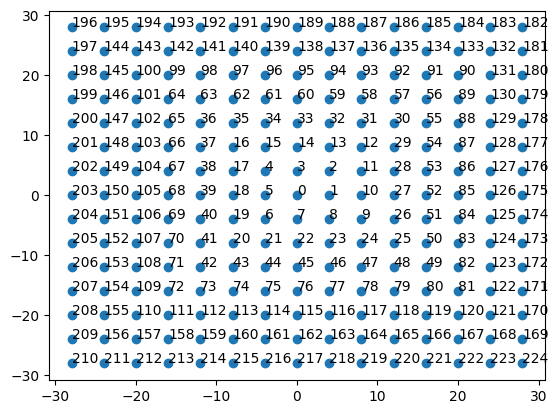

In [ ]:
list_images =[28, 36, 35, 27, 19, 20, 21, 29, 37, 45, 44, 43, 42, 34, 26, 18, 10, 11, 12, 13, 14, 22, 30, 38, 46, 54, 53, 52, 51, 50, 49, 41, 33, 25, 17, 9, 1, 2, 3, 4, 5, 6, 7, 15, 23, 31, 39, 47, 55, 63, 62, 61, 60, 59, 58, 57, 56, 48, 40, 32, 24, 16, 8, 0]#[27,28,20,19,18,26,34,35,36]
j =0
px_new = px.copy()
py_new = py.copy()

list_of_images = np.array(spiral(15, 15)).reshape(225)
for i in list_of_images:
  #print(i,j)x
  px_new[i-1] = px[j]
  py_new[i-1] = py[j]
  j+=1

fig, ax = plt.subplots()

ax.scatter(px_new,py_new)

for i in range(arraysize ** 2):
    ax.annotate(str(i), (px_new[i], py_new[i]))


In [ ]:

blood = loadmat(path)
print(blood)


# print(np.rollaxis(np.array(blood['imlow_HDR']),2).shape)
#annots['imgs'] = new_images
# imgs_train_input2 = annots['imgs']

for name in blood:
    print (name)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Fri Jul 10 22:45:02 2020', '__version__': '1.0', '__globals__': [], 'aberration': array([[0]], dtype=uint8), 'imlow_HDR': array([[[1.15226507e+00, 1.32778490e+00, 1.72028363e+00, ...,
         1.86158658e-03, 1.85195438e-03, 1.89591083e-03],
        [7.31343448e-01, 1.36361885e+00, 1.46702981e+00, ...,
         1.86158658e-03, 1.85195438e-03, 1.89591083e-03],
        [8.20977867e-01, 1.46930456e+00, 1.46702981e+00, ...,
         1.86158658e-03, 1.85195438e-03, 1.89591083e-03],
        ...,
        [8.20977867e-01, 1.29162550e+00, 1.26091814e+00, ...,
         1.86158658e-03, 1.85195438e-03, 1.89591083e-03],
        [1.40529764e+00, 1.29162550e+00, 1.33486426e+00, ...,
         1.86158658e-03, 1.85195438e-03, 1.89591083e-03],
        [1.88255322e+00, 1.72874379e+00, 1.70905232e+00, ...,
         3.13080288e-03, 1.85195438e-03, 1.89591083e-03]],

       [[1.21713364e+00, 1.46930456e+00, 1.67520881e+00, ...,
         4.2

In [ ]:
blood.keys()

dict_keys(['__header__', '__version__', '__globals__', 'aberration', 'imlow_HDR', 'theta', 'wlength', 'xint', 'yint', 'z'])

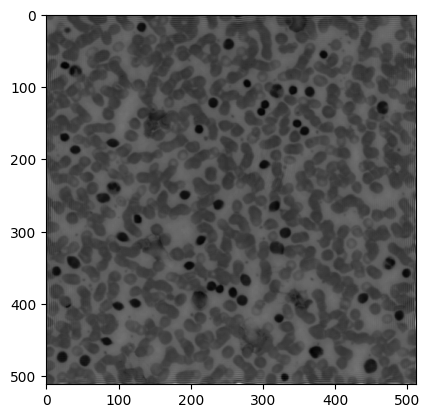

In [ ]:
path ='/content/drive/MyDrive/Fourier-Ptychography-master/Data/bloodsmear_green_result.mat'
result = loadmat(path)

plt.imshow(abs(result['him']),cmap='gray')


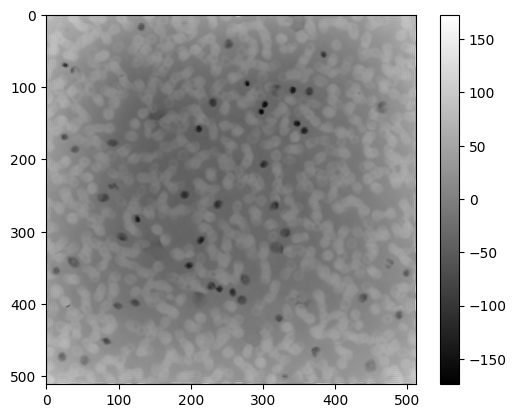

In [ ]:
plt.imshow(np.angle(result['him'], deg=True),cmap='gray')
plt.colorbar()

In [ ]:
#normalise image
if np.angle(result['him']).dtype!='uint8':
    img_cr=(np.angle(result['him']) +np.pi)/(np.pi*2)
    image=img_cr*255
    del(img_cr)
    image=np.array(image, dtype='uint8')
    rec_phase = Image.fromarray(image)
    rec_phase.save("usaf_zhang_phase.png")



In [ ]:
path ='/content/drive/MyDrive/Fourier-Ptychography-master/2024 Etalonnage/spiral_of.mat'
positions = loadmat(path)


px_ = positions['ky'][0] * -1 *k0/dkxy
py_ = positions['kx'][0] * -1 *k0/dkxy

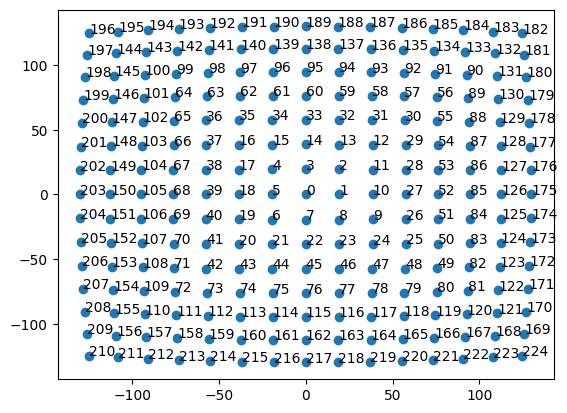

In [ ]:
fig, ax = plt.subplots()

ax.scatter(px_,py_)

for i in range(arraysize ** 2):
    ax.annotate(str(i), (py_[i], px_[i]))


In [ ]:
# Generate CTF

#choose LEDs format
# Format = "Square"
Format = "Square"

imgs_train_input1 = np.ndarray((arraysize ** 2, imSize, imSize, 1),dtype=np.float32) # input CTF
imgs_train_input4 = np.ndarray((int(arraysize ** 2), imSize, imSize, 1),dtype=np.float32) # input CTF
imgs_train_input2 = np.ndarray((int(arraysize**2), original_size, original_size, 1),dtype=np.float32)

kx_input = np.ndarray((arraysize ** 2,1,1),dtype=np.float32) # input measurement
ky_input = np.ndarray((arraysize ** 2,1,1),dtype=np.float32) # input measurement

kx_input_true = np.ndarray((arraysize ** 2,1,1),dtype=np.float32) # input measurement
ky_input_true = np.ndarray((arraysize ** 2,1,1),dtype=np.float32) # input measurement

kxky = spiral_kxky('/content/drive/MyDrive/Fourier-Ptychography-master/spiral_kxky.txt', arraysize ** 2) # load kx, ky here
print('kxky shape:',kxky.shape)

noise_x = 0#4 # 2*4 + 0,5*4
noise_y = 0#4 # 2*4 + 0,5*4
angle_noise = 0#10
distance_ = 1#0.8

for i in range(arraysize ** 2):
    kyIllu = py_new[i]#*NAstep*100
    kxIllu = px_new[i]#*NAstep*100

    kx_input[i,0,0] = ((kxIllu*np.cos(angle_noise) + kyIllu*np.sin(angle_noise)))*distance_ + noise_x
    ky_input[i,0,0] = ((-1*kxIllu*np.sin(angle_noise) + kyIllu*np.cos(angle_noise)))*distance_ + noise_y
    kx_input_true[i,0,0] = ((kxIllu)*-1)
    ky_input_true[i,0,0] =  ((kyIllu)*-1)

    imgs_train_input1[i, :, :, 0] = CTF
    imgs_train_input4[i, :, :, 0] = np.ones(( imSize, imSize),np.float32)


imgs_train_input3 = np.reshape(imgs_train_input1,(arraysize ** 2,imSize* imSize, 1))
imgs_train_input3 = np.concatenate((kx_input,ky_input),axis=1)

imgs_train_input3_true = np.reshape(imgs_train_input1,(arraysize ** 2,imSize* imSize, 1))
imgs_train_input3_true = np.concatenate((kx_input_true,ky_input_true),axis=1)

#uploads low resolution images generated by FPM_generate_low_res
path ='/content/drive/MyDrive/Fourier-Ptychography-master/2024 Etalonnage/bas_reso.mat'

annots = loadmat(path)
print(annots.keys())


imgs_train_input2[:,:,:,0] = np.rollaxis(np.array(blood['imlow_HDR']),2)[:,:,:]


mi = np.amin(imgs_train_input2[:,:,:])
ma = np.amax(imgs_train_input2[:,:,:])
print(mi,ma)

imgs_train_input2 =np.square(255*((imgs_train_input2-mi)/(ma-mi)))
mi = np.amin(imgs_train_input2[:,:,:])
ma = np.amax(imgs_train_input2[:,:,:])

print(mi,ma)
# imgs_train_input2[:,:,:,0] = cell
# print(np.amin(cell[:,:,:]))
# print(np.amax(cell[:,:,:]))

annots['imgs'] = imgs_train_input2[:,:,:,:]

imgs_test_predict = np.sqrt(imgs_train_input2)

imgs_test_predict_resize = np.zeros((225,original_size,original_size ,1),dtype=np.float32)

for i in range(0,arraysize ** 2):
    imgs_test_predict_resize[i,:,:,0] = imgs_test_predict[i,:,:,0]#cv2.resize(imgs_test_predict[i,:,:,:],(imSize,imSize), interpolation = cv2.INTER_AREA)

# imgs_train_input2 = np.power(imgs_test_predict_resize,2)

print('imgs_train_input2 shape = ' +str(imgs_train_input2.shape) +str(imgs_train_input2.dtype))
print('imgs_train_input1 shape = ' +str(imgs_train_input1.shape) +str(imgs_train_input1.dtype))
print('imgs_train_input4 shape = ' +str(imgs_train_input3.shape) +str(imgs_train_input3.dtype))
print('imgs_test_predict shape = ' +str(imgs_test_predict.shape))


kxky shape: (64, 2)
dict_keys(['__header__', '__version__', '__globals__', 'imgs'])
0.0016327675 2.4249873
0.0 65025.0
imgs_train_input2 shape = (225, 128, 128, 1)float32
imgs_train_input1 shape = (225, 512, 512, 1)float32
imgs_train_input4 shape = (225, 2, 1)float32
imgs_test_predict shape = (225, 128, 128, 1)


In [ ]:
model_ = CreateNNModel()
print(arraysize)

15


In [ ]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        #tf.print(model_.get_layer('ky').get_weights()[0][1])
        if epoch%31 ==  0 and epoch//31<3 and epoch//15>0:  # or save after some epoch, each k-th epoch etc.
            ClearComplexObject(model_)

In [ ]:
model_ = CreateNNModel()



In [ ]:
ClearComplexObject(model_)
ClearZernikePolynomials(model_)
CleanPositionsWeights(model_)

pupilTrainable = False
objectComplexTrainable = True
polynomesTrainable = True
kxTrainable = False
kyTrainable = False
angleTrainable = False
distanceTrainable = False
dzTrainable = False

# Appel sans utiliser des mots-clés
SetTrainableLayers(model_, pupilTrainable, objectComplexTrainable, polynomesTrainable, kxTrainable, kyTrainable, angleTrainable, distanceTrainable, dzTrainable)

optimizers = [
  tf.keras.optimizers.Adamax(learning_rate=1e-1), # check function
  tf.keras.optimizers.Adamax(learning_rate=1e-2),
  tf.keras.optimizers.Adamax(learning_rate=2e-1),# kx*w et ky*w 3e-1 ou 2e-1
  tf.keras.optimizers.Adamax(learning_rate=1e-1), #dz
  tf.keras.optimizers.Adam(learning_rate=1e-1,amsgrad=True),
  tf.keras.optimizers.Adam(learning_rate=1e3,amsgrad=True) #1e2
]

optimizers_and_layers = [
    (optimizers[0], model_.layers[3:4]), # rotation globale
    (optimizers[1], model_.layers[4:5]), # distance globale
    (optimizers[2], model_.layers[5:7]), # shift
    (optimizers[3], model_.layers[7:8]), # dz
    (optimizers[4], model_.layers[10:11]), # zernike
    (optimizers[5], model_.layers[12:]) # Objet Complex\
]

file_path = 'loss_cout.mat'

optimizer = tfa.optimizers.MultiOptimizer(optimizers_and_layers)

model_.compile(loss=[f_loss,tv_loss], optimizer=optimizer)

history3 = model_.fit([imgs_train_input3[0:225], imgs_train_input2[0:225], imgs_train_input4[0:225]],
                      [imgs_test_predict_resize[0:225], imgs_test_predict_resize[0:225]],
                      batch_size=1, epochs=10, verbose=1,
                      shuffle=False, callbacks=[CustomSaver()])


Epoch 1/10


225/225 [==============================] - 33s 106ms/step - loss: 1.0132 - out_loss: 0.7893 - out_1_loss: 0.2239
Epoch 2/10
225/225 [==============================] - 24s 107ms/step - loss: 0.9936 - out_loss: 0.7726 - out_1_loss: 0.2210
Epoch 3/10
225/225 [==============================] - 24s 106ms/step - loss: 0.9587 - out_loss: 0.7401 - out_1_loss: 0.2186
Epoch 4/10
225/225 [==============================] - 22s 99ms/step - loss: 0.9828 - out_loss: 0.7643 - out_1_loss: 0.2184
Epoch 5/10
225/225 [==============================] - 24s 106ms/step - loss: 0.9729 - out_loss: 0.7556 - out_1_loss: 0.2173
Epoch 6/10
225/225 [==============================] - 22s 99ms/step - loss: 0.9652 - out_loss: 0.7489 - out_1_loss: 0.2163
Epoch 7/10
225/225 [==============================] - 24s 106ms/step - loss: 0.9574 - out_loss: 0.7419 - out_1_loss: 0.2155
Epoch 8/10
225/225 [==============================] - 22s 97ms/step - loss: 0.9501 - out_loss: 0.7353 - out_1_loss: 0.2148
Epoch 9/10
225/225 [==

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Supposons que model_ est déjà votre modèle chargé
print("Résumé du modèle:")
model_.summary()

# Pour inspecter une couche spécifique par son index, par exemple la dernière couche
output_layer = model_.layers[-1]  # changez l'index selon le besoin
print("Configuration de la dernière couche de sortie:", output_layer.get_config())


Résumé du modèle:
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_all (InputLayer)      [(None, 2, 1)]               0         []                            
                                                                                                  
 input_x (Lambda)            (None, 1)                    0         ['input_all[0][0]']           
                                                                                                  
 input_y (Lambda)            (None, 1)                    0         ['input_all[0][0]']           
                                                                                                  
 angle (pos_angle)           [(None, 1),                  1         ['input_x[0][0]',             
                              (None, 1)]                             'inpu

In [ ]:
model_path = './mon_modele'  # Sauvegarde dans le répertoire courant sous le dossier 'mon_modele'
model_.save(model_path)
print(f"Le modèle a été sauvegardé dans le chemin suivant : {model_path}")


Le modèle a été sauvegardé dans le chemin suivant : ./mon_modele


In [ ]:
import tensorflow as tf

# Chemin vers l'image de test
image_path = 'usaf_zhang_phase.png'

# Charger l'image
image = tf.io.read_file(image_path)
image = tf.image.decode_png(image, channels=1)  # Utilisez decode_jpeg pour les JPEG, et ajustez 'channels' si nécessaire
image = tf.image.convert_image_dtype(image, tf.float32)  # Convertir en float pour le prétraitement

# Vous pourriez avoir besoin de redimensionner l'image pour qu'elle corresponde à l'entrée du modèle
image = tf.image.resize(image, [512, 512])  # Ajustez la taille selon les besoins de votre modèle

# Ajouter une dimension de batch pour correspondre à l'entrée du modèle
image = tf.expand_dims(image, axis=0)


In [ ]:
angle = model_.get_layer('angle').get_weights()[0][0]
distance_x = model_.get_layer('distance').get_weights()[0][0]
distance_y = model_.get_layer('distance').get_weights()[0][1]
delta_x = model_.get_layer('kx').get_weights()[0][0]
delta_y = model_.get_layer('ky').get_weights()[0][0]
delta_z = model_.get_layer('dz').get_weights()[0][0]

In [ ]:
w_conv_Or = model_.get_layer('O_FTr').get_weights()
w_conv_Oi = model_.get_layer('O_FTi').get_weights()
w_conv_Or_array = np.asarray(w_conv_Or)
w_conv_Oi_array = np.asarray(w_conv_Oi)
c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))

c_complex = (c_real + 1j * c_imag)

In [ ]:
scipy.io.savemat(file_path, {'loss':history3.history['loss'],'angle': angle,'dx':distance_x,'dy':distance_y,'deltax':delta_x,'deltay': delta_y, 'deltaz':delta_z,'complex':c_complex})

In [ ]:

# Charger le fichier .mat
data = scipy.io.loadmat(file_path)

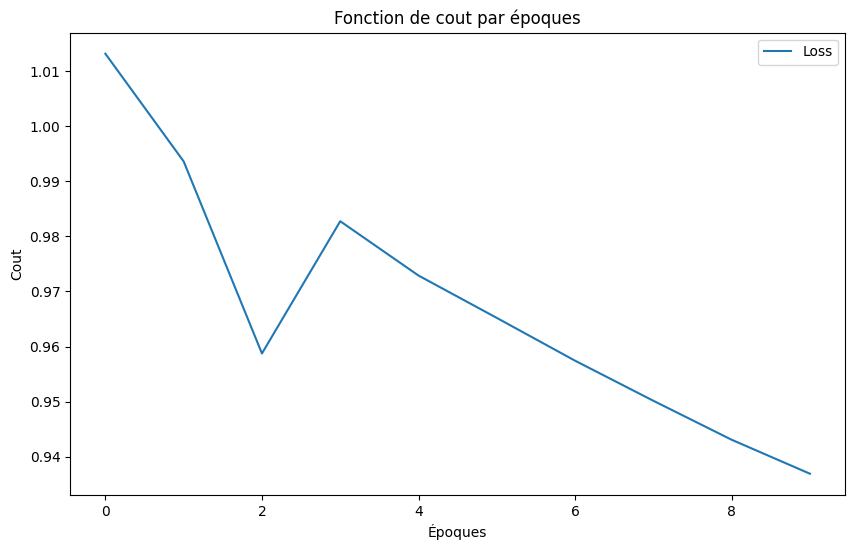

In [ ]:
# Extraire les données de perte
loss = data['loss'].flatten()  # Utiliser flatten() si loss est stocké comme un tableau 2D d'une seule colonne

# Tracer le graphique de la perte en fonction des époques
plt.figure(figsize=(10, 6))
plt.plot(loss, label='Loss')
plt.title('Fonction de cout par époques')
plt.xlabel('Époques')
plt.ylabel('Cout')
plt.legend()
plt.show()


In [ ]:
x = (kx_input*np.cos(angle) + ky_input*np.sin(angle))*distance_x + delta_x
y = (-kx_input*np.sin(angle) + ky_input*np.cos(angle))*distance_y +delta_y

print(x[4],kx_input[4])
sqrt = tf.math.sqrt((x*x) + (y*y) + ((dz+delta_z)*(dz+delta_z)))
new_pos_x = (k0*(x/sqrt))/dkxy
new_pos_y = (k0*(y/sqrt))/dkxy



sqrt_ = tf.math.sqrt((kx_input*kx_input) + (ky_input*ky_input) + ((dz)*(dz)))
pos_x_ = (k0*(kx_input/sqrt_))/dkxy
pos_y_ = (k0*(ky_input/sqrt_))/dkxy

sqrt_2 = tf.math.sqrt((kx_input_true*kx_input_true) + (ky_input_true*ky_input_true) + ((dz)*(dz)))
pos_x_2 = (k0*(kx_input_true/sqrt_2))/dkxy
pos_y_2 = (k0*(ky_input_true/sqrt_2))/dkxy

[[-4.]] [[-4.]]


In [ ]:
;fig, ax = plt.subplots(figsize=(10, 10))

#ax.scatter(kx_input,ky_input, s=40,marker='x', edgecolors='r',color='red', label="Approximate initial positions")
#print(kx_w)
ax.scatter(x,y, s=40,marker='s', edgecolors='g',facecolors='none',label='Optimized positions')
ax.scatter(kx_input,ky_input, s=40,marker='o', edgecolors='b',facecolors='none',label='Original positions')
#ax.scatter(new_pos_x,new_pos_y, s=40,marker='x', edgecolors='b',facecolors='blue',label="Ground truth matrix of LEDs")

ax.legend()


<ipython-input-77-86046b5b73d6>:8: UserWarning: You passed a edgecolor/edgecolors ('g') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(pos_x_2,pos_y_2, s=40,marker='x', edgecolors='g',facecolors='green',label="Ground truth matrix of LEDs")


Text(0.5, 0, 'kx')

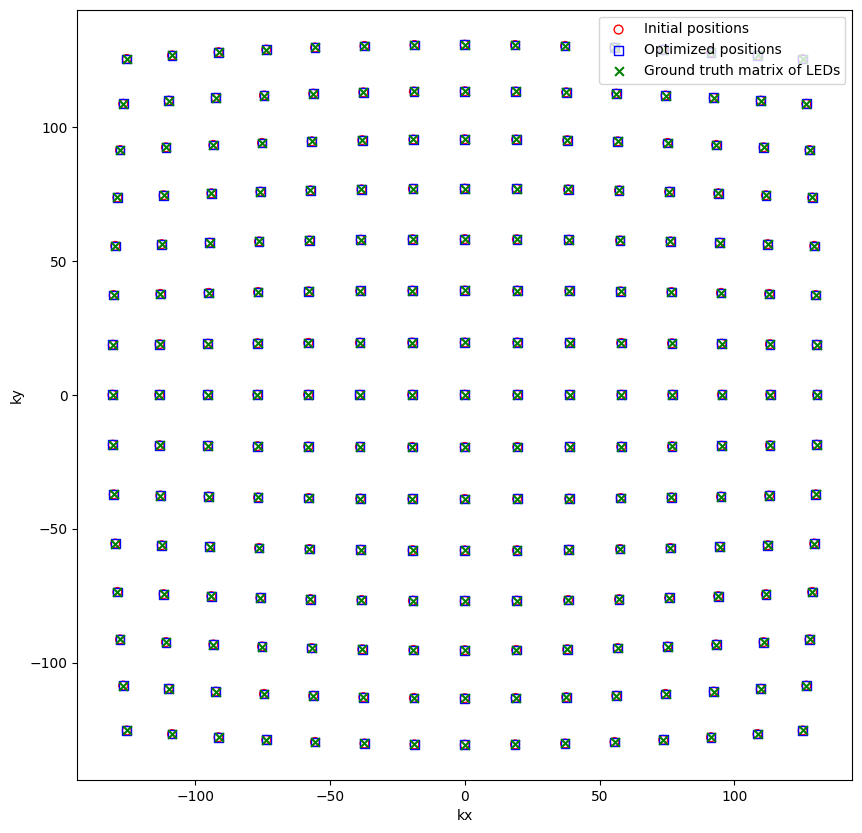

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

#ax.scatter(kx_input,ky_input, s=40,marker='x', edgecolors='r',color='red', label="Initial positions")
#print(kx_w)

ax.scatter(pos_x_,pos_y_, s=40,marker='o', edgecolors='r',facecolors='none',label='Initial positions')
ax.scatter(new_pos_x,new_pos_y, s=40,marker='s', edgecolors='b',facecolors='none',label='Optimized positions')
ax.scatter(pos_x_2,pos_y_2, s=40,marker='x', edgecolors='g',facecolors='green',label="Ground truth matrix of LEDs")

ax.legend()

ax.set_ylabel('ky')
ax.set_xlabel('kx')

In [ ]:
!pip install opencv-python-headless

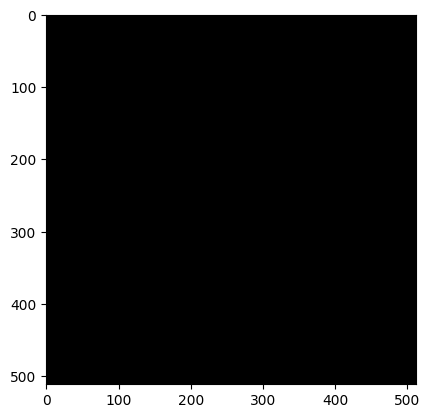

In [ ]:
import cv2

new_CTF = CTF.copy()
mask_all_ctf = np.zeros((imSize,imSize))

for i in range(0,arraysize**2):
    translation_matrix = np.float32([ [1,0,new_pos_y[i][0][0]], [0,1,new_pos_x[i][0][0]] ])
    img_translation = cv2.warpAffine(new_CTF, translation_matrix, (imSize, imSize))
    mask_all_ctf = mask_all_ctf + img_translation

mask_all_ctf[mask_all_ctf>=0] =1
plt.imshow(mask_all_ctf,cmap='gray')

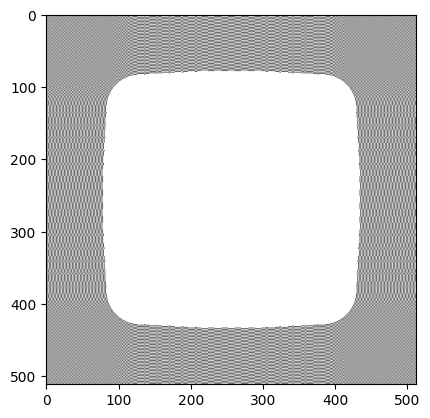

In [ ]:
import numpy as np
from scipy.ndimage import affine_transform
import matplotlib.pyplot as plt

# new_CTF = CTF.copy()  # Supposé que CTF est déjà défini
# imSize = taille de votre image, par exemple 256
# arraysize = la dimension de votre grille, par exemple 16
# new_pos_y et new_pos_x sont vos tableaux de positions

mask_all_ctf = np.zeros((imSize, imSize))

for i in range(0, arraysize**2):
    # dx et dy sont les déplacements en x et y
    dy, dx = new_pos_y[i][0][0], new_pos_x[i][0][0]

    # Appliquer la translation sans rotation ni mise à l'échelle
    img_translation = affine_transform(new_CTF, np.eye(2), offset=[-dy, -dx], output_shape=(imSize, imSize))

    # Accumuler les translations
    mask_all_ctf = mask_all_ctf + img_translation

# Binariser le masque
mask_all_ctf[mask_all_ctf >= 0] = 1

# Afficher le résultat
plt.imshow(mask_all_ctf, cmap='gray')
plt.show()


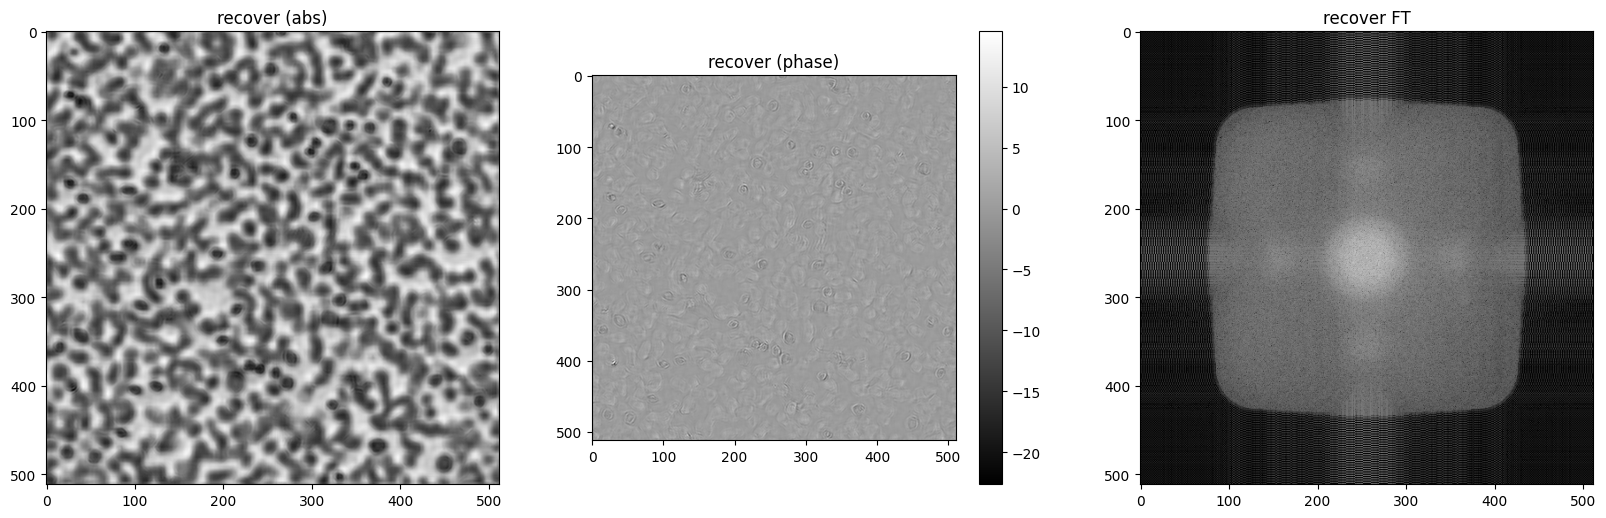

In [ ]:
imRecover = show_result(model_,mask_all_ctf, 1,noShow=0)
#K.clear_session()

In [ ]:
# pour des petites deplacement

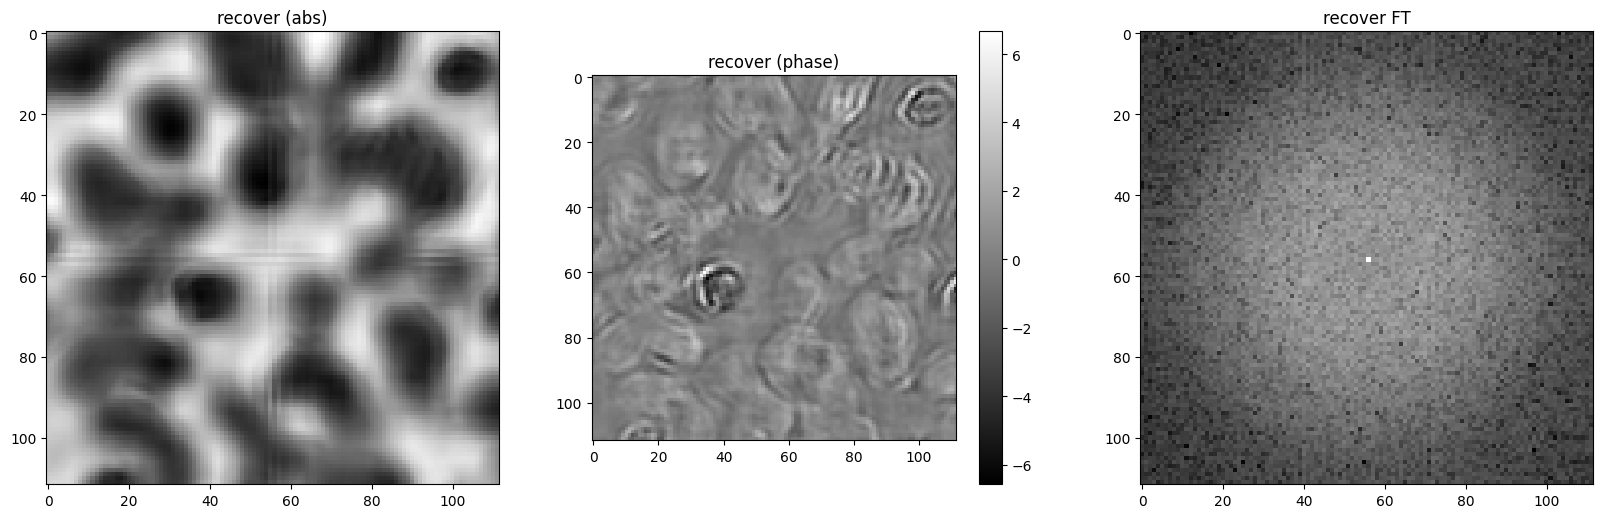

In [ ]:
imRecover = show_result(model_,mask_all_ctf, 1,noShow=200)
#K.clear_session()

In [ ]:
import scipy.io
import matplotlib.pyplot as plt

# Remplacez 'chemin/vers/votre/fichier.mat' par le chemin réel de votre fichier .mat
file_path = 'greenrecover_abs.mat'

# Charger le fichier .mat
data = scipy.io.loadmat(file_path)

# Supposons que les données d'image sont stockées sous la clé 'data' dans le fichier .mat
# Remplacez 'data' par la clé réelle si elle est différente
image_data = data['data']

# Afficher l'image
# Si l'image est en niveaux de gris, utilisez cmap='gray' pour un affichage approprié
plt.imshow(image_data, cmap='gray')
plt.colorbar()  # Affiche une barre de couleur pour les images en niveaux de gris
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'greenrecover_abs.mat'

In [ ]:
save_data_for_figures(model_, mask_all_ctf, file_prefix='green')

array([[ 1.05762313e-114-0.00000000e+000j,
        -7.90332365e+000+1.09174140e-001j,
         1.51372874e-113+4.23229201e-115j, ...,
        -7.93803024e+000+1.13127068e-001j,
         2.19648768e-112-6.14124381e-114j,
        -7.90332365e+000-1.09174140e-001j],
       [-8.38733768e+000-6.52654842e-002j,
         1.43738714e-113+5.98730019e-116j,
        -8.26889610e+000-1.79393277e-001j, ...,
         2.83250871e-111-1.49135093e-112j,
        -8.17706299e+000+1.51944244e-002j,
         2.10757391e-112-4.58452431e-114j],
       [ 1.53705278e-113+2.44944958e-115j,
        -8.04055405e+000-4.87045228e-001j,
         2.07232982e-112+5.81393623e-114j, ...,
        -8.14435959e+000+7.70834461e-002j,
         2.94399299e-111+1.12436522e-112j,
        -8.28884888e+000+1.97073705e-002j],
       ...,
       [-8.31965065e+000-2.47396734e-002j,
         5.69223499e-111-2.57860633e-112j,
        -8.21542263e+000+1.61535919e-001j, ...,
        -7.82586956e+000+5.73904574e-001j,
         5.27344676

In [ ]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data'])

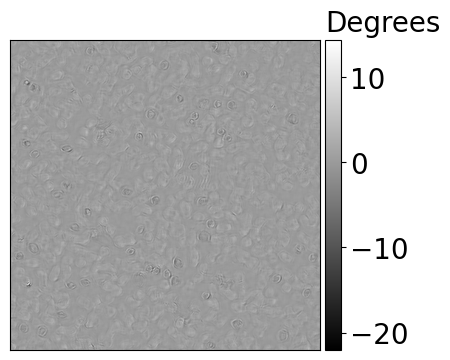

In [ ]:
w_conv_Or = model_.get_layer('O_FTr').get_weights()
w_conv_Oi = model_.get_layer('O_FTi').get_weights()
w_conv_Or_array = np.asarray(w_conv_Or)
w_conv_Oi_array = np.asarray(w_conv_Oi)
c_real = w_conv_Or_array[0, :, :, 0].reshape((imSize, imSize))
c_imag = w_conv_Oi_array[0, :, :, 0].reshape((imSize, imSize))

c_complex = (c_real + 1j * c_imag)*mask_all_ctf
c_abs = np.abs(c_complex)
c_phase = np.angle(c_complex+pi)
im_spatial = np.abs(np.fft.ifft2(np.fft.ifftshift(c_complex)))**2
im_phase = np.angle(np.fft.ifft2(np.fft.ifftshift(c_complex)))
c_complexFTLog = np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(c_complex)))))
#     objFTLog = np.log(np.abs(np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(obj)))))



image = im_spatial
#normalise image
if image.dtype!='uint8':
    img_cr=(image -image.min())/(image.max()-image.min())
    image=img_cr*255
    del(img_cr)
    image=np.array(image, dtype='uint8')
    rec_spatial = Image.fromarray(image)
    rec_spatial.save("usaf_whitout pupil opt pos opt.png")

image = im_phase
#normalise image
if image.dtype!='uint8':
    img_cr=(image +np.pi)/(np.pi*2)
    image=img_cr*255
    del(img_cr)
    image=np.array(image, dtype='uint8')
    rec_phase = Image.fromarray(image)
    rec_phase.save("usaf_whitout pupil opt pos opt phase .png")




    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(imSize/120, imSize/120)
    im = ax.imshow(np.rad2deg(im_phase),cmap='gray')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(im, cax=cax)
    cbar.ax.tick_params(labelsize=20)
    cbar.ax.set_title('Degrees',fontsize=20,loc='left')
    ax.yaxis.set_major_locator(plt.NullLocator()) # remove y axis ticks
    ax.xaxis.set_major_locator(plt.NullLocator()) # remove x axis ticks
    plt.savefig("colorbar_usaf_whitout pupil opt pos opt pahse .png", dpi=120)
